# Stop and frisk under Mayor Bloomberg

## Imports and dependencies

This notebook was written for Python3. It requires [Pandas](https://pandas.pydata.org/), [Matplotlib](https://matplotlib.org/), [Seaborn](https://seaborn.pydata.org/), and [ffmpeg](https://ffmpeg.org/).

All packages are available via conda (I used the version of ffmpeg under the conda-forge channel):

```
$ conda install -c conda-forge pandas seaborn matplotlib ffmpeg
```

In [2]:
%matplotlib inline

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sns.set_style('whitegrid')
sns.set_palette('colorblind')

os.chdir('/Users/msto/projects/stop-and-frisk')

## Data cleaning

Mayor Bloomberg was mayor from 2002 through 2013; NYPD provides [stop-and-frisk statistics](https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page) since 2003.

I performed some basic cleaning (stripping whitespace around columns and converting to UTF-8) before loading in here.

In [3]:
years = list(range(2003, 2014))

dfs = []
for year in years:
    df = pd.read_csv('data/cleaned/{0}.csv'.format(year), encoding='utf-8')
    
    # 2006 is the only year where stop dates aren't formatted as month day year
    if year == 2006:
        df['Date'] = pd.to_datetime(df.datestop.astype(str), format='%Y-%m-%d')
    # Single digit months in the other years are sometimes missing the leading zero; 
    # add if necessary before converting to datetime
    else:
        df['Date'] = pd.to_datetime(df.datestop.astype(str).apply(lambda x: '0' + x if len(x) == 7 else x), format='%m%d%Y')
        
    dfs.append(df)
        
df = pd.concat(dfs, sort=False)

/Users/msto/.miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,73,74,95,99,103,105,108) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/msto/.miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,21,73,74,100,104,108) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/msto/.miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/msto/.miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (73,74) have mixed types. Specif

Races in these tables are annotated with a single character. I found the key for these characters in the [NYPD's SQF file documentation](https://www1.nyc.gov/assets/nypd/downloads/zip/analysis_and_planning/stop-question-frisk/SQF-File-Documentation.zip).

In [4]:
race_key = {
    'A': 'ASIAN/PACIFIC ISLANDER',
    'B': 'BLACK',
    'I': 'AMERICAN INDIAN/ALASKAN NATIVE',
    'P': 'BLACK-HISPANIC',
    'Q': 'WHITE-HISPANIC',
    'W': 'WHITE',
    'X': 'UNKNOWN',
    'Z': 'OTHER'
}

In addition to replacing the characters with the full name, I combined white and black Hispanic stops into a single group. (This makes it easier to compare with the NYC demographic data later on, which only has a single Hispanic category.)

In [5]:
df['Race'] = df.race.replace(race_key)
df['Race'] = df.Race.replace({'WHITE-HISPANIC': 'HISPANIC', 'BLACK-HISPANIC': 'HISPANIC'})

Finally I obtained estimates of the current size of each demographic in NYC as of 2018 from the [US Census](https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,NY,US/PST045219).

In [9]:
total_pop = 8398748
black_pct = .243
hispanic_pct = .291
white_pct = .321

pop = {'WHITE': int(white_pct * total_pop),
       'BLACK': int(black_pct * total_pop), 
       'HISPANIC': int(hispanic_pct * total_pop)}

## Counting stops

For this animation, I limited the counts to stops of white, black, and Hispanic people. I counted the number of stops of each demographic per day over the full 2003-2013 timespan.

In [7]:
races = ['WHITE', 'BLACK', 'HISPANIC']
idx = pd.MultiIndex.from_product(iterables=[races, pd.date_range('2003-01-01', '2013-12-31')]) 

stops = df.groupby(['Race', 'Date']).size().reindex(idx).fillna(0).astype(int)

## Main figure

This is the final figure that the animation grows toward.

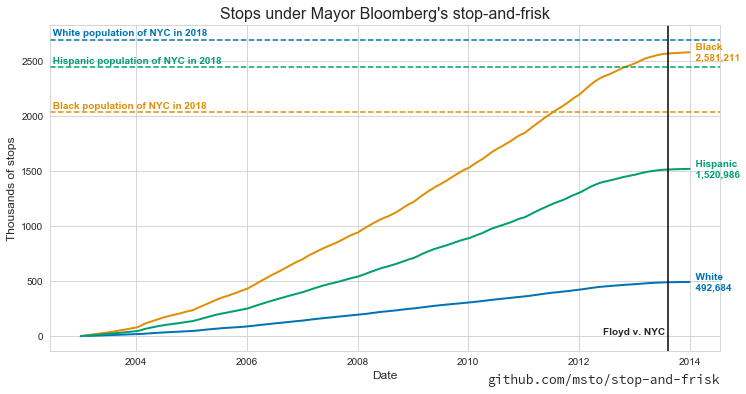

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for i, race in enumerate(races):
    color = sns.color_palette('colorblind')[i]
    
    # Plot the cumulative number of stops over time
    data = stops.loc[race].cumsum() / 1000
    ax.plot(data.index, data, label=race, linewidth=2)

    # Label the end of each curve
    xval = data.index.max()
    yval = data[data.index.max()]
    ax.text(xval, yval, '  {0}\n  {1:,}'.format(race.capitalize(), int(yval * 1000)), 
            va='center', color=color, fontweight="bold")
    
    # Add lines marking the total population of each demographic
    xval = ax.get_xlim()[0]
    yval = pop[race] / 1000
    ax.axhline(yval, c=color, linestyle='--')
    ax.text(xval, yval + 15, " {0} population of NYC in 2018".format(race.capitalize()), 
            va='bottom', ha='left', fontweight='bold', color=color)

# Mark the Floyd v NYC court decision
floyd_date = pd.to_datetime('2013-08-12', format='%Y-%m-%d')
ax.axvline(floyd_date, c='k')
ax.text(floyd_date, 0, 'Floyd v. NYC ',
        fontweight='bold', va='bottom', ha='right')#, fontsize=11)
    
# Axis labels
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Thousands of stops", fontsize=12)
ax.set_title("Stops under Mayor Bloomberg's stop-and-frisk", fontsize=16)

# Citation
ax.text(1, -0.07, 'github.com/msto/stop-and-frisk', 
        ha='right', va='top', fontsize=13,
        fontname='Source Code Pro', transform=ax.transAxes)

# Save
plt.savefig('figures/bloomberg_stop_and_frisk.png', bbox_inches='tight')

## Animation

Matplotlib requires a function that plots each frame of the animation. This function plots our data up to a given time point.

In [26]:
def animate(i):
    global fig, ax, years, days_per_frame
    ax.clear()
    
    for j, race in enumerate(races):
        color = sns.color_palette('colorblind')[j]
        
        # Count the cumulative number of stops in 1000s, then plot
        max_idx = int(i * days_per_frame + 1)
        if max_idx > stops.loc[race].shape[0]:
            data = stops.loc[race].iloc[:int(i * days_per_frame + 1)].cumsum() / 1000
        else:
            data = stops.loc[race].iloc[:int(i * days_per_frame + 1)].cumsum() / 1000
        ax.plot(data.index, data, label=race, linewidth=2, c=color)

        # Label the end of the curve with demographic and count
        xval = data.index.max()
        yval = data[data.index.max()]
        ax.text(xval, yval, '  {0}\n  {1:,}'.format(race.capitalize(), int(yval * 1000)), 
                va='center', color=color, fontweight="bold")
        
    # Matplotlib's animate will automatically resize the figure to contain everything plotted.
    # We don't want to plot the total demographic population or Floyd decision until
    # we reach them
    
    # We plot all demographic counts first, so the axis ylimit is updated maximally
    # Then, if the window is large enough, plot each of the demographics' total pop as of 2018
    for j, race in enumerate(races):
        color = sns.color_palette('colorblind')[j]
        xval = ax.get_xlim()[0]
        yval = pop[race] / 1000
        if yval <= ax.get_ylim()[1]:
            ax.axhline(yval, c=color, linestyle='--')
            ax.text(xval, yval + 15, " {0} population of NYC in 2018".format(race.capitalize()), 
                    va='bottom', ha='left', fontweight='bold', color=color)#
        
    # If we're later than the Floyd decision, mark it on the figure
    floyd_date = pd.to_datetime('2013-08-12', format='%Y-%m-%d')
    if floyd_date < data.index.max():
        ax.axvline(floyd_date, c='k')
        ax.text(floyd_date, 0, 'Floyd v. NYC ',
                fontweight='bold', va='bottom', ha='right')#, fontsize=11)
    
    # Axis labels
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Thousands of stops", fontsize=12)
    ax.set_title("Stops under Mayor Bloomberg's stop-and-frisk", fontsize=16)
    
    # Citation
    ax.text(1, -0.07, 'github.com/msto/stop-and-frisk', 
            ha='right', va='top', fontsize=13,
            fontname='Source Code Pro', transform=ax.transAxes)

Then we build our animation. I updated each frame five days at a time so the animation would be under 30 seconds.

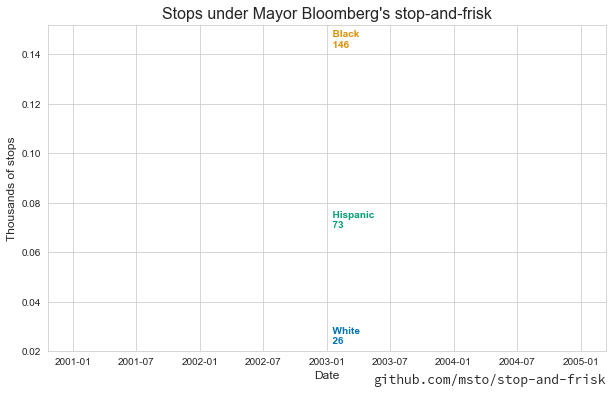

In [28]:
fps = 45
Writer = animation.writers['ffmpeg']
writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

days_per_frame = 5
ani = animation.FuncAnimation(fig, animate, frames=int(365 / days_per_frame) * len(years), repeat=True)
ani.save('figures/bloomberg_stop_and_frisk.{0}fps.mp4'.format(fps), writer=writer)